# "Multivariate time-series forecasting with Pytorch LSTMs"
> "Using recurrent neural networks for standard tabular time-series problems"

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [python, lstm, pytorch]
- hide: false
- search_exclude: true

In a [previous post](https://charlieoneill11.github.io/charlieoneill/lstm/pytorch/2022/01/12/lstm1.html), I went into detail about constructing an LSTM for univariate time-series data. This itself is not a trivial task; you need to understand the form of the data, the shape of the inputs that we feed to the LSTM, and how to recurse over training inputs to produce an appropriate output. This knowledge is fantastic for analysing curves where the only information we have is the past values of the curve itself. For instance, we can use univariate LSTMs to learn trigonometric curves, and plot them well outside the domain of training values.

Whilst it is all well and good to take one array of data, representing a sequence of values of a function over time, and attempt to predict future values, this often doesn't match the quantity of data available in the real world. More likely, the data we receive will be in tabular form, with each row representing a singular time step. Each row probably consists of several different columns; these are the features, or _predictors_, that we have information about at each time step. One of these columns is not a feature, however. It is the _target_ we want to predict. Consequently, we need a way to feed in these multiple values at each time step to our LSTM, and to produce a singular output representing the prediction at the next time step in return. In this way, we construct a __multivariate__ LSTM.

In [1]:
# hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Predicting Tesla stock price
For this problem, we're going to focus on financial data. Before we begin, I would like to point out that LSTMs will not make you rich, even if they are excellent forecasters for time-series data. __No__ model will make you rich; there's a whole field of thinking on epistemic humility and how impossible it is for anything you do to detect any edge in the market; I won't go into it here. But know this: if you've found an inconsistency in the price of a stock (it's too low, or too high and you want to capitalise on that), and you believe that no-one else has spotted this inconsistency, then you might want to rethink your surety. Recall that "no-one else" in this scenario includes the team of PhDs sitting in Goldman Sachs with a supercomputing cluster, the lowest latency in information and order processing in the market, and multi-billion dollar financial incentives to find exactly the same inconsistencies as you. If you really believe you've beaten them, you haven't. For more detail on this line of thinking, see Eliezer Yudkowsky’s [_Inadequate Equilibria_](https://equilibriabook.com/toc/).

We'll frame our problem as follows. We have historical price data for Bitcoin, which includes the following predictors for each day (where we have daily time steps):
* Opening price
* High price
* Low price
* Volume traded
Our target is closing price at each time step. 

### Preprocessing and exploratory analysis
We begin by importing the data and quickly cleaning it. Fortunately, financial data is readily available online. We will use Yahoo historical prices for Bitcoin, available back to September 17, 2014. This data is available [here](https://finance.yahoo.com/quote/BTC-USD/history?period1=1410912000&period2=1642118400&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true). Import the data using Pandas and have a look.

> Note: you can download historical data here for almost any 

In [53]:
df = pd.read_csv('BTC-USD.csv', index_col = 'Date', parse_dates=True)
df.drop(columns=['Adj Close'], inplace=True)
df.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


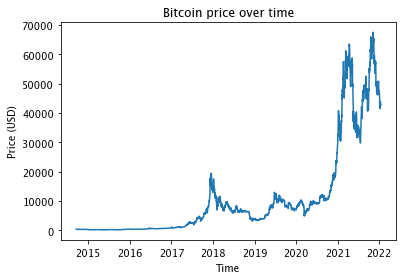

In [54]:
plt.plot(df.Close)
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Bitcoin price over time")
plt.show();

### Setting inputs and outputs

In [36]:
X, y = df.drop(columns=['Close']), df.Close.values
X.shape, y.shape

((2908, 4), (2908,))

In [37]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y.reshape(-1, 1)) 

In [38]:
total_samples = len(df)
train_test_cutoff = round(0.95 * total_samples)

# train-test split (200, 53)
X_train = X_ss[:train_test_cutoff, :]
X_test = X_ss[train_test_cutoff:, :]

y_train = y_mm[:train_test_cutoff, :]
y_test = y_mm[train_test_cutoff:, :] 

In [39]:
print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (2763, 4) (2763, 1)
Testing Shape: (145, 4) (145, 1)


In [40]:
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

In [41]:
# convert to pytorch tensors
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [42]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 1, 
                                       X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 1, 
                                      X_test_tensors.shape[1])) 

In [43]:
print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([2763, 1, 4]) torch.Size([2763, 1])
Testing Shape: torch.Size([145, 1, 4]) torch.Size([145, 1])


In [44]:
X_train

array([[-0.52724312, -0.52222316, -0.52889522,  2.21562311],
       [-0.52139729, -0.51765683, -0.52381251,  1.93547103],
       [-0.52207744, -0.52144806, -0.52648623,  0.3444833 ],
       ...,
       [ 2.02865129,  2.02000896,  2.07419204, -0.32786393],
       [ 2.04737705,  2.07464471,  2.1087828 , -0.30809078],
       [ 2.09679535,  2.1036266 ,  2.15493291, -0.24211525]])

### LSTM model

In [45]:
class LSTM(nn.Module):
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes # number of classes
        self.num_layers = num_layers # number of layers
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # hidden state
        self.seq_length = seq_length # sequence length
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected 1
        self.fc = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()
        
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # internal state
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc(out) # final Output
        return out

### Training

In [46]:
def training_loop(n_epochs, lstm, optimiser, loss_fn):
    for epoch in range(n_epochs):
        outputs = lstm.forward(X_train_tensors_final) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train_tensors)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

In [47]:
n_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 4 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 1 # number of output classes 

In [48]:
lstm = LSTM(num_classes, 
              input_size, 
              hidden_size, 
              num_layers, 
              X_train_tensors_final.shape[1]) # our lstm class

In [49]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate) 

In [50]:
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn)

Epoch: 0, loss: 0.11437
Epoch: 100, loss: 0.00162
Epoch: 200, loss: 0.00026
Epoch: 300, loss: 0.00019
Epoch: 400, loss: 0.00014
Epoch: 500, loss: 0.00010
Epoch: 600, loss: 0.00007
Epoch: 700, loss: 0.00005
Epoch: 800, loss: 0.00004
Epoch: 900, loss: 0.00003


### Prediction

In [51]:
df_X_ss = ss.transform(df.drop(columns=['Close'])) # old transformers
df_y_mm = mm.transform(df.Close.values.reshape(-1, 1)) # old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) # converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

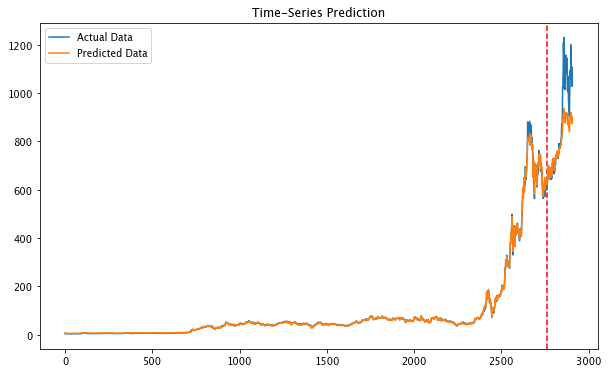

In [52]:
train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 